# Gesture Recognition
We will develop a 3D Convolutional model capable of accurately recognizing and predicting all five gestures.

In [1]:
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import skimage
from skimage.transform import resize
import datetime
import cv2
import abc
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)
BASE_PATH = 'datasets/Project_data'

### Overview

We will design a hybrid architecture that integrates a Convolutional Neural Network (CNN) with a Recurrent Neural Network (RNN). In this approach, the Conv2D network extracts feature vectors from images, which are then processed as a sequence by the RNN. The RNN interprets these sequential features, and its output is passed through a softmax layer for classification.

To streamline development, we will create a BuildModel class as an abstract foundation for constructing models and data generators specifically for gesture recognition in smart TVs. This class will handle key configurations such as file paths, image properties, and hyperparameters. It will also provide essential functionalities for batch data generation, model training, and an abstract method for defining the model architecture.

## Generator

In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [2]:
class BuildModel(metaclass=abc.ABCMeta):

    def initialize_path(self, BASE_PATH):

        self.train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
        self.train_path = 'datasets/Project_data/train'
        self.val_path = 'datasets/Project_data/val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_props(self, image_height=100, image_width=100):

        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):

        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    def generator(self, source_path, folder_list, augment=False):

        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_samples = len(t) % batch_size

            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):

        seq_length = remaining_samples if remaining_samples else batch_size

        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_length, self.num_classes))

        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))


        for folder in range(seq_length):
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))


                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])


        return(batch_data, batch_labels)


    def train_model(self, model, augment_data=False):

        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def model_definition(self):
        pass


### Visualization of Training and Validation Metrics

This can be accomplished using the `plot` function, which visualizes the training and validation loss, along with `categorical accuracy` and `validation categorical accuracy`. It utilizes the training metrics stored in the history object returned by `model.fit()`. The generated plot consists of two subplots, each illustrating the progression of a specific metric over epochs.

In [3]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

### Model 1 - CNN with LSTM

In [4]:
class RNNCNN1(BuildModel):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
rnn_cnn_1 = RNNCNN1()
rnn_cnn_1.initialize_path(BASE_PATH)
rnn_cnn_1.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_1.initialize_hyperparameters(number_of_sample_frames=30, batch_size=20, num_epochs=20)
rnn_cnn_model_1 = rnn_cnn_1.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 30, 60, 60, 32)  

In [32]:
print("Total Parameters: ", rnn_cnn_model_1.count_params())
model_1 = rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4322 - categorical_accuracy: 0.3605
Epoch 00001: val_loss improved from inf to 1.67995, saving model to model_init_2025-04-0213_48_20.503718/model-00001-1.43221-0.36048-1.67995-0.22000.keras
34/34 [==============================] - 209s 6s/step - loss: 1.4322 - categorical_accuracy: 0.3605 - val_loss: 1.6799 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1590 - categorical_accuracy: 0.5030
Epoch 00002: val_loss did not improve from 1.67995
34/34 [==============================] - 177s 5s/step - loss: 1.1590 - categorical_accuracy: 0.5030 - val_loss: 1.9942 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0632 - categorical_accuracy: 0.5694
Epoch 00003: val_loss did not improve from 1.67995
34/34 [==============================] - 178s 5s/step - loss: 1.

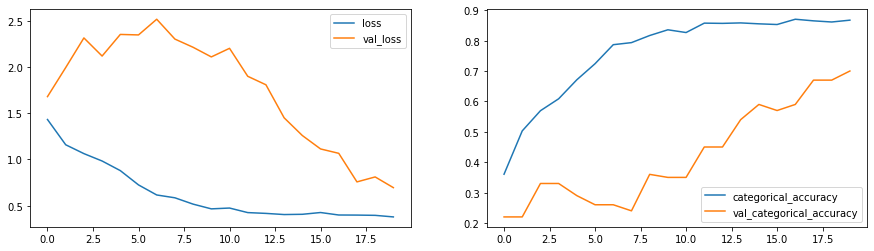

In [33]:
plot(model_1)

### Model 2 - CNN with LSTM (with reduced hyperparameters)

In [5]:
rnn_cnn_2 = RNNCNN1()
rnn_cnn_2.initialize_path(BASE_PATH)
rnn_cnn_2.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_2.initialize_hyperparameters(number_of_sample_frames=20, batch_size=10, num_epochs=10)
rnn_cnn_model_2 = rnn_cnn_2.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_2.summary()

2025-04-02 15:41:22.580575: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-04-02 15:41:22.580641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21985 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:61:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)   1

In [35]:
print("Total Parameters: ", rnn_cnn_model_2.count_params())
model_2 = rnn_cnn_2.train_model(rnn_cnn_model_2, augment_data=True)

Total Parameters:  1657445
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.4269 - categorical_accuracy: 0.3680
Epoch 00001: val_loss improved from inf to 1.81326, saving model to model_init_2025-04-0214_51_47.681305/model-00001-1.42689-0.36802-1.81326-0.21000.keras
67/67 [==============================] - 127s 2s/step - loss: 1.4269 - categorical_accuracy: 0.3680 - val_loss: 1.8133 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2331 - categorical_accuracy: 0.4736
Epoch 00002: val_loss did not improve from 1.81326
67/67 [==============================] - 123s 2s/step - loss: 1.2331 - categorical_accuracy: 0.4736 - val_loss: 2.8004 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.1535 - categorical_accuracy: 0.5015
Epoch 00003: val_loss did not improve from 1.81326
67/67 [==============================] - 123s 2s/step - loss: 1.

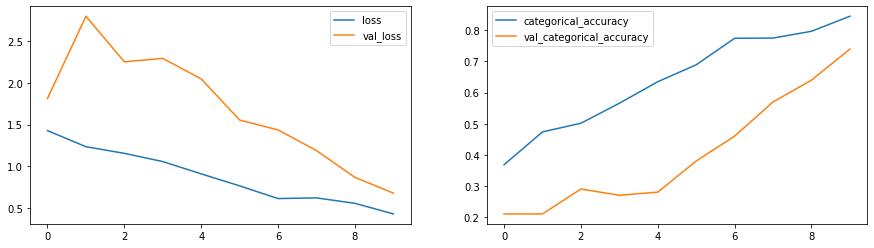

In [36]:
plot(model_2)

### Model 3 - CNN with LSTM (with reduced frames)

In [6]:
rnn_cnn_3 = RNNCNN1()
rnn_cnn_3.initialize_path(BASE_PATH)
rnn_cnn_3.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_3.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_3 = rnn_cnn_3.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32)  

In [7]:
print("Total Parameters: ", rnn_cnn_model_3.count_params())
model_3 = rnn_cnn_3.train_model(rnn_cnn_model_3, augment_data=True)

Total Parameters:  1657445
Epoch 1/20


2025-04-02 15:41:55.840955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-04-02 15:41:57.524932: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


34/34 [==============================] - ETA: 0s - loss: 1.3849 - categorical_accuracy: 0.3786
Epoch 00001: val_loss improved from inf to 1.78355, saving model to model_init_2025-04-0215_41_50.302279/model-00001-1.38494-0.37858-1.78355-0.17000.keras
34/34 [==============================] - 106s 3s/step - loss: 1.3849 - categorical_accuracy: 0.3786 - val_loss: 1.7835 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1020 - categorical_accuracy: 0.5400
Epoch 00002: val_loss did not improve from 1.78355
34/34 [==============================] - 93s 3s/step - loss: 1.1020 - categorical_accuracy: 0.5400 - val_loss: 2.1848 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9545 - categorical_accuracy: 0.6131
Epoch 00003: val_loss did not improve from 1.78355
34/34 [==============================] - 92s 3s/step - loss: 0.9545 - categorical_accuracy: 0.6131 - va

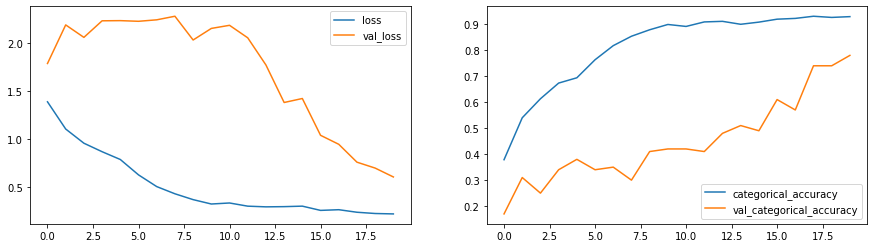

In [8]:
plot(model_3)

### Model 4 - CNN with GRU

In [9]:
class RNNCNN2(BuildModel):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
rnn_cnn_4 = RNNCNN2()
rnn_cnn_4.initialize_path(BASE_PATH)
rnn_cnn_4.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_4.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_4 = rnn_cnn_4.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 32)  

In [11]:
print("Total Parameters: ", rnn_cnn_model_4.count_params())
model_4 = rnn_cnn_4.train_model(rnn_cnn_model_4, augment_data=True)

Total Parameters:  2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4796 - categorical_accuracy: 0.3695
Epoch 00001: val_loss improved from inf to 2.67487, saving model to model_init_2025-04-0216_12_56.054544/model-00001-1.47956-0.36953-2.67487-0.19000.keras
34/34 [==============================] - 95s 3s/step - loss: 1.4796 - categorical_accuracy: 0.3695 - val_loss: 2.6749 - val_categorical_accuracy: 0.1900 - lr: 0.0020
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2269 - categorical_accuracy: 0.4751
Epoch 00002: val_loss did not improve from 2.67487
34/34 [==============================] - 90s 3s/step - loss: 1.2269 - categorical_accuracy: 0.4751 - val_loss: 2.7853 - val_categorical_accuracy: 0.1600 - lr: 0.0020
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0843 - categorical_accuracy: 0.5430
Epoch 00003: val_loss improved from 2.67487 to 2.09119, saving model to model_init_2025-04-0216_12_56.054544/model-00

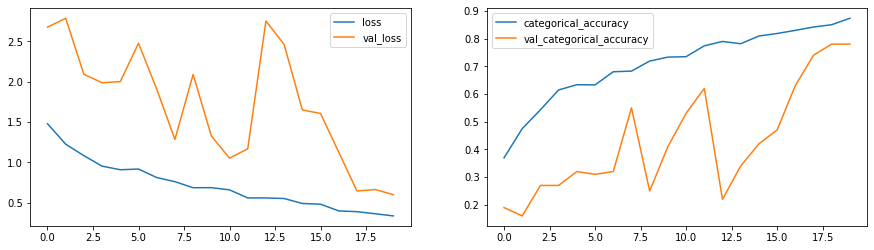

In [12]:
plot(model_4)

### Enhance `BuildModel` class to incorporate additional augmentation techniques such as `Rotation`

In [14]:
class BuildModelWithRotation(metaclass=abc.ABCMeta):

    def initialize_path(self, BASE_PATH):

        self.train_doc = np.random.permutation(open(BASE_PATH + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(BASE_PATH + '/' + 'val.csv').readlines())
        self.train_path = BASE_PATH + '/' + 'train'
        self.val_path = BASE_PATH + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_props(self, image_height=100, image_width=100):

        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):

        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    def generator(self, source_path, folder_list, augment=False):

        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_samples = len(t) % batch_size

            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):

        seq_length = remaining_samples if remaining_samples else batch_size

        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_length, self.num_classes))

        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))


        for folder in range(seq_length):
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))


                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    matrix2d = cv2.getRotationMatrix2D((self.image_width//2, self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, matrix2d, (self.image_width, self.image_height))

                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])


        return(batch_data, batch_labels)


    def train_model(self, model, augment_data=False):

        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def model_definition(self):

        pass


### Model 5 - CNN with LSTM (with modified Augmentation Technique)

In [15]:
class RNNCNN3(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn_5 = RNNCNN3()
rnn_cnn_5.initialize_path(BASE_PATH)
rnn_cnn_5.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_5.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_5 = rnn_cnn_5.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 18, 60, 60, 32)  

In [17]:
print("Total Parameters: ", rnn_cnn_model_5.count_params())
model_5 = rnn_cnn_5.train_model(rnn_cnn_model_5, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4166 - categorical_accuracy: 0.3876
Epoch 00001: val_loss improved from inf to 1.68932, saving model to model_init_2025-04-0216_44_00.209821/model-00001-1.41656-0.38763-1.68932-0.21000.keras
34/34 [==============================] - 93s 3s/step - loss: 1.4166 - categorical_accuracy: 0.3876 - val_loss: 1.6893 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1777 - categorical_accuracy: 0.5219
Epoch 00002: val_loss did not improve from 1.68932
34/34 [==============================] - 90s 3s/step - loss: 1.1777 - categorical_accuracy: 0.5219 - val_loss: 1.9290 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0484 - categorical_accuracy: 0.5671
Epoch 00003: val_loss did not improve from 1.68932
34/34 [==============================] - 92s 3s/step - loss: 1.048

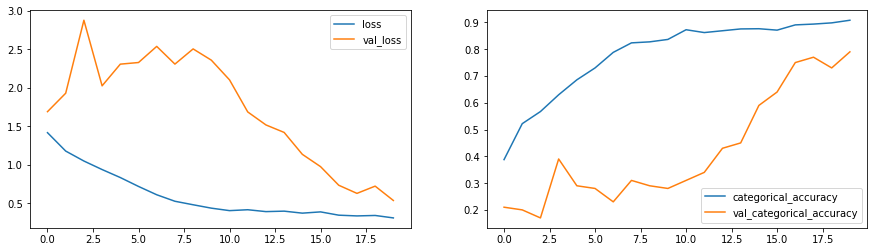

In [18]:
plot(model_5)

### Model 6 - CNN with LSTM (with Transfer Learning)

In [19]:
class RNNCNN_TL_LSTM(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn_6 = RNNCNN_TL_LSTM()
rnn_cnn_6.initialize_path(BASE_PATH)
rnn_cnn_6.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_6.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_6 = rnn_cnn_6.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_61 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 128)              

In [21]:
print("Total Parameters: ", rnn_cnn_model_6.count_params())
model_6 = rnn_cnn_6.train_model(rnn_cnn_model_6, augment_data=True)

Total Parameters:  3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3486 - categorical_accuracy: 0.4223
Epoch 00001: val_loss improved from inf to 0.93558, saving model to model_init_2025-04-0217_14_33.172334/model-00001-1.34860-0.42232-0.93558-0.57000.keras
133/133 [==============================] - 80s 592ms/step - loss: 1.3486 - categorical_accuracy: 0.4223 - val_loss: 0.9356 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9718 - categorical_accuracy: 0.6056
Epoch 00002: val_loss improved from 0.93558 to 0.72770, saving model to model_init_2025-04-0217_14_33.172334/model-00002-0.97178-0.60558-0.72770-0.67000.keras
133/133 [==============================] - 77s 580ms/step - loss: 0.9718 - categorical_accuracy: 0.6056 - val_loss: 0.7277 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7066 - categorical_accuracy: 

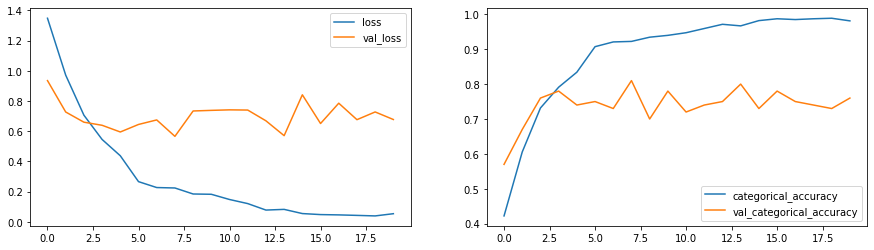

In [22]:
plot(model_6)

### Model 7 - CNN with LSTM (with trainable weights of Transfer Learning)

In [23]:
class RNNCNN_TL_LSTM_2(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))

        # Training weights
        for layer in model.layers:
            layer.trainable = True


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn_7 = RNNCNN_TL_LSTM_2()
rnn_cnn_7.initialize_path(BASE_PATH)
rnn_cnn_7.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_7.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_7 = rnn_cnn_7.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 128)              

In [25]:
print("Total Parameters: ", rnn_cnn_model_7.count_params())
model_7 = rnn_cnn_7.train_model(rnn_cnn_model_7, augment_data=True)

Total Parameters:  3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3166 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 0.96166, saving model to model_init_2025-04-0217_40_32.307729/model-00001-1.31662-0.43891-0.96166-0.63000.keras
133/133 [==============================] - 81s 599ms/step - loss: 1.3166 - categorical_accuracy: 0.4389 - val_loss: 0.9617 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9591 - categorical_accuracy: 0.6237
Epoch 00002: val_loss did not improve from 0.96166
133/133 [==============================] - 76s 576ms/step - loss: 0.9591 - categorical_accuracy: 0.6237 - val_loss: 1.3286 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7839 - categorical_accuracy: 0.6923
Epoch 00003: val_loss improved from 0.96166 to 0.55447, saving model to model_init_2025-04-0217_40_32

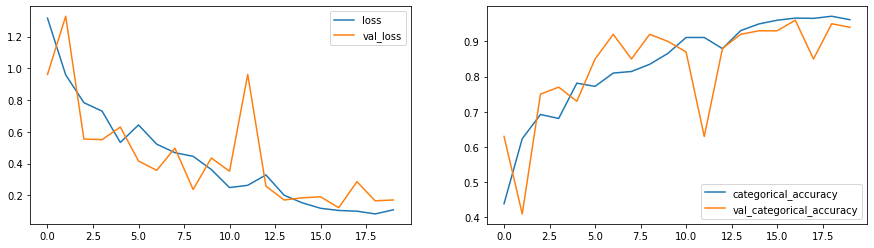

In [27]:
plot(model_7)

### Model 8 - CNN with GRU  (with trainable weights of Transfer Learning)

In [28]:
class RNNCNN_TL_GRU(BuildModelWithRotation):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
rnn_cnn_8 = RNNCNN_TL_GRU()
rnn_cnn_8.initialize_path(BASE_PATH)
rnn_cnn_8.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_8.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_8 = rnn_cnn_8.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_8.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_69 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [30]:
print("Total Parameters: ", rnn_cnn_model_8.count_params())
model_8 = rnn_cnn_8.train_model(rnn_cnn_model_8, augment_data=True)

Total Parameters:  3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2011 - categorical_accuracy: 0.5008
Epoch 00001: val_loss improved from inf to 0.68545, saving model to model_init_2025-04-0218_06_33.977374/model-00001-1.20107-0.50075-0.68545-0.76000.keras
133/133 [==============================] - 80s 589ms/step - loss: 1.2011 - categorical_accuracy: 0.5008 - val_loss: 0.6855 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6311 - categorical_accuracy: 0.7519
Epoch 00002: val_loss improved from 0.68545 to 0.49679, saving model to model_init_2025-04-0218_06_33.977374/model-00002-0.63115-0.75189-0.49679-0.84000.keras
133/133 [==============================] - 76s 573ms/step - loss: 0.6311 - categorical_accuracy: 0.7519 - val_loss: 0.4968 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.3853 - categorical_accuracy: 

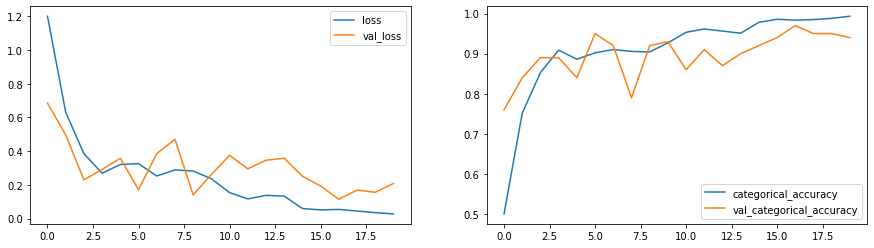

In [31]:
plot(model_8)

In [ ]:
rnn_cnn_model_8.save('model/final.h5')